In [2]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data -->

In [4]:
hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

# hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

# hit_data_1056 = rf.get_ROOT_data_zip("TB_FIRE_1056_hits.root")

# hit_data_1057 = rf.get_ROOT_data_zip("TB_FIRE_1057_hits.root")

# hit_data_1079 = rf.get_ROOT_data_zip("TB_FIRE_1079_hits.root")

TB_FIRE_1101_hits.root finished


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes -->

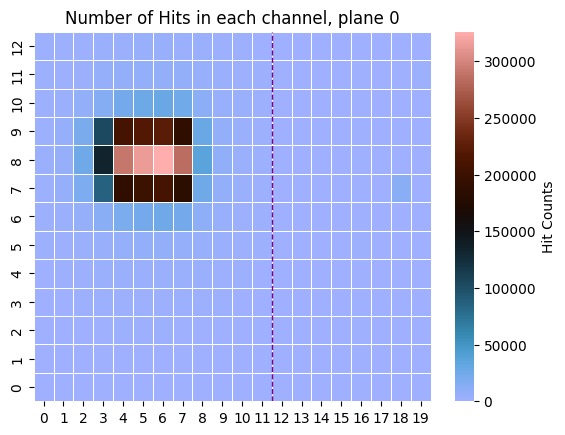

In [3]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 0, cmap="berlin")

In [ ]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 7, cmap="managua")

In [6]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 0, cmap="managua")

In [7]:
# rf.single_event_evolution_amp(hit_data_1101, 54106, cmap="managua")

In [8]:
# plt.clf()   # Clear the current figure
# plt.close() # Close any open figures
# %matplotlib widget
# rf.amp_histo_single_plane(hit_data_1101,1)

In [11]:
# rf.average_amp_vs_plane(hit_data_1101)

In [ ]:
# # shower initial starting plane
# rf.plot_empty_first_planes(hit_data_1101)

In [45]:
a = ak.Array([1,2,4,4,5])
mask = a == 4
mask

<Array [False, False, True, True, False] type='5 * bool'>

1086090
1086090
457960
457960


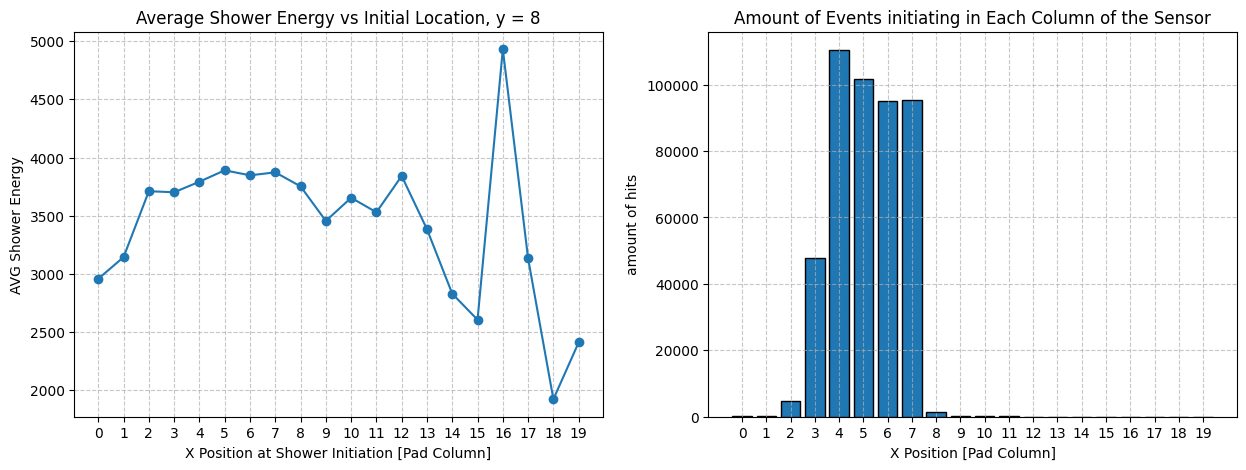

In [5]:
def event_shower_energy_vs_X_position(hit_data, single_pad_only = "false", specific_Y = "false"):
    
    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data[hit_data.plane == 7]
    if single_pad_only == "false":
        mask = ak.num(plane_7) > 0

    if single_pad_only == "true":
        mask = ak.num(plane_7) == 1

    first_plane_starting_events = hit_data[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    
    # get the x and y positions of each channel
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    
    # make x and y one dimensional
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)


        
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)

    print(len(x_avg))
    print(len(event_shower_amp_array))

    if specific_Y  != "false":
        y = ak.flatten(y)
        mask_Y = y == specific_Y
        x_avg = x_avg[mask_Y]
        event_shower_amp_array = event_shower_amp_array[mask_Y]

    print(len(x_avg))
    print(len(event_shower_amp_array))
    # get the average shower energy for each X position
    div, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)


    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot the energy avg per position vs the initial X position of the shower
    ax1.plot(classes, avg_amps, marker='o')
    ax1.set_xticks(np.arange(0, 20))
    ax1.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
    ax1.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    ax1.set_xlabel('X Position at Shower Initiation [Pad Column]')
    ax1.set_ylabel('AVG Shower Energy')
    
    if specific_Y == "false":
        ax1.set_title('Average Shower Energy vs Initial Location')
    
    else:
        ax1.set_title(f'Average Shower Energy vs Initial Location, y = {specific_Y}')

    # show the amounnt of hits in each plane on a bar chart
    bins = np.arange(0, 21, 1) 
    ax2.hist(x_avg, bins=bins, edgecolor='black', rwidth=0.8)
    ax2.set_xticks(np.arange(0, 20) + 0.5)  # shift by 0.5
    ax2.set_xticklabels(np.arange(0, 20)) 
    ax2.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
    ax2.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    ax2.set_xlabel('X Position [Pad Column]')
    ax2.set_ylabel('amount of hits')
    ax2.set_title('Amount of Events initiating in Each Column of the Sensor')
    
    

    plt.show()


event_shower_energy_vs_X_position(hit_data_1101, single_pad_only="true", specific_Y = 8)

1086090
1086090
457960
457960


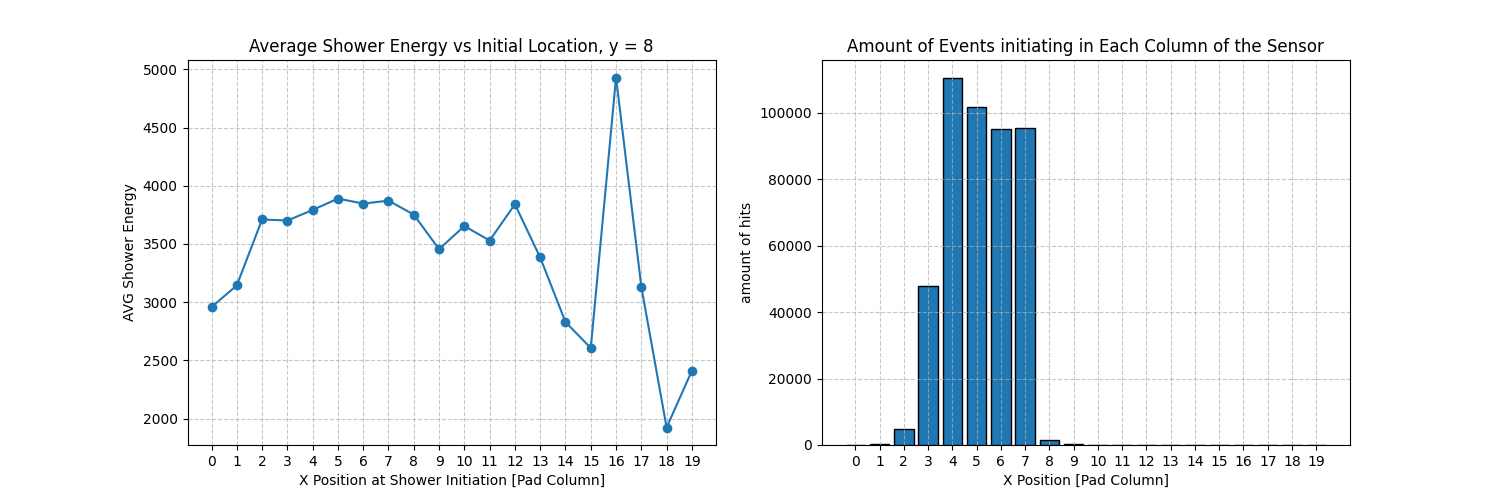

In [6]:
plt.clf()   # Clear the current figure
plt.close() # Close any open figures
%matplotlib widget
rf.event_shower_energy_vs_X_position(hit_data_1101, single_pad_only="true", specific_Y = 8)

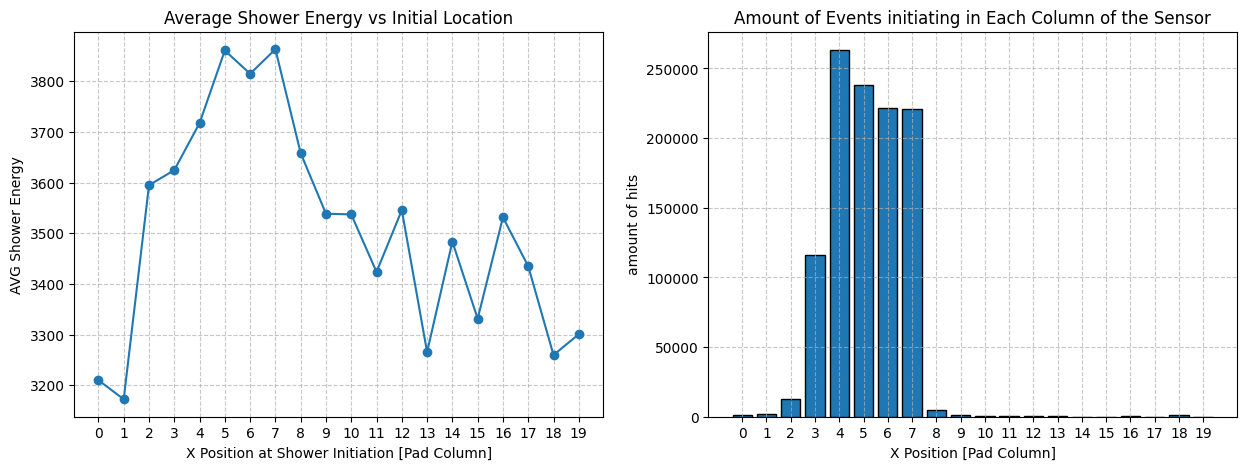

In [32]:
rf.event_shower_energy_vs_X_position(hit_data_1101, single_pad_only="true")

In [26]:
# returns histogram of the amount of hits with the same energy in given X position
def shower_energy_histo_single_location(hit_data, Position):

    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data_1101[hit_data_1101.plane == 7]
    mask = ak.num(plane_7) > 0
    first_plane_starting_events = hit_data_1101[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    print("avg ok")
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)
    print("shower per event ok")
    # get the shower energy for the X position for all events
    amps_divided_by_class, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    print("groupby ok")
    # div, avg_amps, classes = ak_groupby(x_avg, event_shower_amp_array)

    amps_class_position = amps_divided_by_class[amps_divided_by_class.classes == Position]
    print("amps class at position ok")
    amps_position = amps_class_position.data
    print("amp position ok")
    amps_position_clean = amps_position[ak.num(amps_position) > 0]
    print("amp position clean ok")




    # Plot
    plt.hist(amps_position_clean[0], bins=7001, range=(0,14000))
    plt.show()



avg ok
shower per event ok
groupby ok
amps class at position ok
amp position ok
amp position clean ok


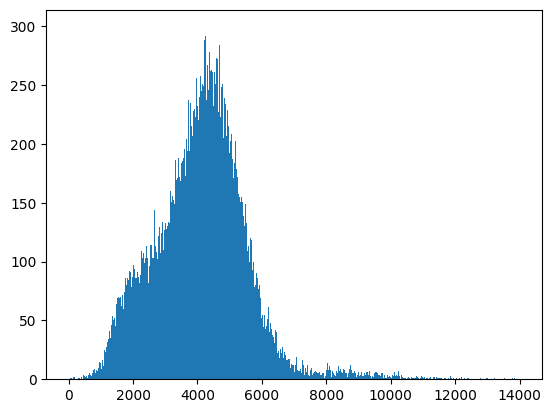

In [27]:
shower_energy_histo_single_location(hit_data_1101,5)


In [4]:
rf.initial_X_position_DUT(hit_data_1101, return_y = "true")
# rf.initial_X_position_DUT(hit_data_1101)

(<Array [4, 6, 4, 3, 5.5, 5, ..., 5, 3, 5, 7, 5.5, 4.5] type='2154539 * float64'>,
 <Array [8, 9, 8.5, 8, 7.5, 7, ..., 7, 8, 7, 8, 8, 8.5] type='2154539 * float64'>)

In [9]:
# rf.avg_hit_amount_vs_plane_per_X_position(hit_data_1101,6)

In [28]:
# rf.Histo_shower_energy_for_X_position(hit_data_1101, 6, single_pad_only = "true")

In [29]:
# rf.avg_ENERGY_vs_plane_per_X_position(hit_data_1101, 6, print_energies = "true")


In [30]:
a = rf.Radii_from_Initial_position(hit_data_1101)

In [31]:
a

<Array [[{plane: 0, ch: 128, ...}, ...], ...] type='1086090 * var * {plane:...'>